In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/csv-preprocessed/csv_preprocessed.csv
/kaggle/input/5g-nidd-dataset/Combined.csv


In [2]:
# import shutil

# input_path = '/kaggle/input/csv-preprocessed'
# output_path = '/kaggle/working/csv-preprocessed'
# # Copy dataset into working directory
# shutil.copytree(input_path, output_path)

In [3]:
cd /kaggle/working/csv-preprocessed

/kaggle/working/csv-preprocessed


In [4]:
!pip install torch
!pip install torchmetrics --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 20.9 MB/s eta 0:00:0000:01
  Attempting uninstall: torchmetrics
    Found existing installation: torchmetrics 1.3.1
    Uninstalling torchmetrics-1.3.1:
      Successfully uninstalled torchmetrics-1.3.1


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
import scipy
import sklearn
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
import torchmetrics

In [6]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
print('Device:', torch.device('cuda:0'))
device

Torch 2.1.2 CUDA 12.1
Device: cuda:0


device(type='cuda')

In [7]:
# number of subprocesses to use for data loading
num_workers = multiprocessing.cpu_count()

# how many samples per batch to load
batch_size = 64

# percentage of data set to use as validation
valid_size = 0.15

In [8]:
df = pd.read_csv('csv_preprocessed.csv', low_memory=False)
print(df.shape)
df.head()

(1215675, 63)


,Dur,sTos,dTos,sTtl,dTtl,sHops,dHops,TotPkts,SrcPkts,DstPkts,...,Cause_Status,State_ACC,State_CON,State_ECO,State_FIN,State_INT,State_REQ,State_RST,State_URP,Attack Type
0,-0.807085,-0.069046,-0.094739,-0.419379,-0.00732,1.050111,-0.973059,-0.167011,-0.146696,-0.115856,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
1,-0.807085,-0.069046,-0.094739,-0.419379,-0.00732,1.050111,-0.973059,-0.167011,-0.146696,-0.115856,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
2,2.147963,-0.069046,-0.094739,0.635573,-0.00732,2.452913,-0.973059,8.414004,10.443194,1.327973,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,2.147973,-0.069046,-0.094739,0.635573,-0.00732,2.452913,-0.973059,7.205410,8.651059,1.568612,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,2.148810,-0.069046,-0.094739,0.635573,-0.00732,2.452913,-0.973059,8.776582,10.877651,1.408186,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [9]:
num_classes = df['Attack Type'].nunique()
print(num_classes)

9


In [27]:
# Train Test split
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Attack Type']), df['Attack Type'],
                                                    stratify=df['Attack Type'], 
                                                    test_size=0.15, 
                                                    random_state = 42)


X_train = pd.DataFrame(X_train, columns=df.drop(columns=['Attack Type']).columns.to_list())
X_test = pd.DataFrame(X_test, columns=df.drop(columns=['Attack Type']).columns.to_list())
y_train = pd.DataFrame(y_train, columns=['Attack Type'])
y_test = pd.DataFrame(y_test, columns=['Attack Type'])

print("Training dataset size:", X_train.shape)
print("Testing dataset size:", X_test.shape)
print("Training target size:", y_train.shape)
print("Testing target size:", y_test.shape)

Training dataset size: (1033323, 62)
Testing dataset size: (182352, 62)
Training target size: (1033323, 1)
Testing target size: (182352, 1)


In [46]:
# Number of features
num_features = X_train.shape[1]

In [11]:
class CustomTabularDataset(Dataset):
    def __init__(self, data):
        # Load and preprocess your tabular data here
        self.features = torch.tensor(data['features'].values, dtype=torch.float32)
        self.labels = torch.tensor(data['labels'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [38]:
# Creating a PyTorch class
# input_features ==> 12 ==> 32
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Building an linear encoder with Linear
        # layer followed by Tanh activation function
        # input_features ===> 12
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(num_features, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 16),
            torch.nn.Tanh(),
            torch.nn.Linear(16, 12),
            torch.nn.Tanh(),  
        )
        
        # Dense neural network layers
        self.dense_nn = torch.nn.Sequential(
            torch.nn.Linear(12, 32),  # Input size is 12 from the encoder
            torch.nn.BatchNorm1d(32),            
            torch.nn.ReLU(), 
            torch.nn.Dropout(0.2),            
            torch.nn.Linear(32, 64),
            torch.nn.BatchNorm1d(64),                
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),              
            torch.nn.Linear(64, 32),
            torch.nn.BatchNorm1d(32),                
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),            
            torch.nn.Linear(32, num_classes),  # Output size is the number of classes
            torch.nn.Softmax(dim=1)
        )        

    def forward(self, x):
        encoded = self.encoder(x)
        output = self.dense_nn(encoded)
        return output

In [42]:
# Model Initialization
model = Autoencoder()

# Validation using CrossEntropyLoss function
loss_function = torch.nn.CrossEntropyLoss()

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
                            lr = 0.001,
                            weight_decay = 1e-8)

# number of epochs to train the model
n_epochs = 8

In [23]:
# Define the number of folds
n_splits = 5

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

Fold 1/5
Training dataset size: (826658, 62)
Validation dataset size: (206665, 62)


100%|██████████| 3230/3230 [00:08<00:00, 385.51it/s]


Epoch: 1 	Training Loss: 1.376596 	Validation Loss: 1.376386
Epoch: 1 	Training Accuracy: 99.540318 	Validation Accuracy: 99.557738
Training loss decreased (inf --> 1.376596).
Validation loss decreased (inf --> 1.376386).  Saving model ...
Validation Loss: 1.3764, Validation Accuracy: 99.56%


100%|██████████| 3230/3230 [00:08<00:00, 384.68it/s]


Epoch: 2 	Training Loss: 1.376386 	Validation Loss: 1.375202
Epoch: 2 	Training Accuracy: 99.560641 	Validation Accuracy: 99.677739
Training loss decreased (1.376596 --> 1.376386).
Validation loss decreased (1.376386 --> 1.375202).  Saving model ...
Validation Loss: 1.3752, Validation Accuracy: 99.68%


100%|██████████| 3230/3230 [00:08<00:00, 375.39it/s]


Epoch: 3 	Training Loss: 1.376599 	Validation Loss: 1.375357
Epoch: 3 	Training Accuracy: 99.537535 	Validation Accuracy: 99.661771


100%|██████████| 3230/3230 [00:08<00:00, 384.19it/s]


Epoch: 4 	Training Loss: 1.376342 	Validation Loss: 1.375375
Epoch: 4 	Training Accuracy: 99.562818 	Validation Accuracy: 99.660804


100%|██████████| 3230/3230 [00:08<00:00, 381.84it/s]


Epoch: 5 	Training Loss: 1.375883 	Validation Loss: 1.375632
Epoch: 5 	Training Accuracy: 99.609391 	Validation Accuracy: 99.634191


100%|██████████| 3230/3230 [00:08<00:00, 384.69it/s]


Epoch: 6 	Training Loss: 1.376476 	Validation Loss: 1.375109
Epoch: 6 	Training Accuracy: 99.548060 	Validation Accuracy: 99.686933


100%|██████████| 3230/3230 [00:08<00:00, 380.49it/s]


Epoch: 7 	Training Loss: 1.375959 	Validation Loss: 1.376663
Epoch: 7 	Training Accuracy: 99.601044 	Validation Accuracy: 99.531125


100%|██████████| 3230/3230 [00:08<00:00, 391.64it/s]


Epoch: 8 	Training Loss: 1.376088 	Validation Loss: 1.377182
Epoch: 8 	Training Accuracy: 99.587254 	Validation Accuracy: 99.478867


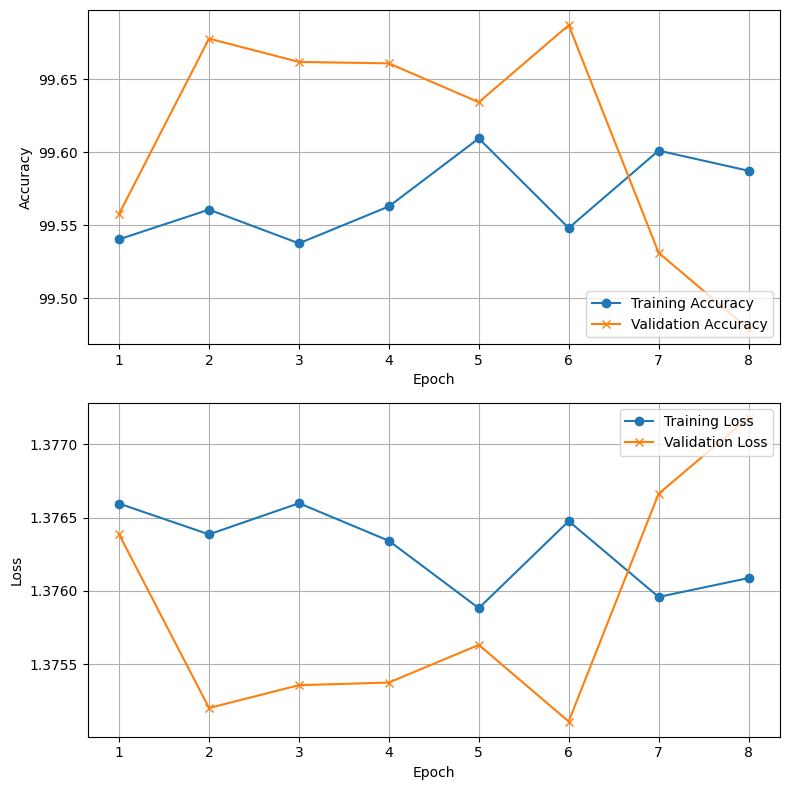

Fold 2/5
Training dataset size: (826658, 62)
Validation dataset size: (206665, 62)


100%|██████████| 3230/3230 [00:08<00:00, 394.71it/s]


Epoch: 1 	Training Loss: 1.376534 	Validation Loss: 1.375034
Epoch: 1 	Training Accuracy: 99.542374 	Validation Accuracy: 99.691288


100%|██████████| 3230/3230 [00:08<00:00, 394.89it/s]


Epoch: 2 	Training Loss: 1.375874 	Validation Loss: 1.375782
Epoch: 2 	Training Accuracy: 99.608907 	Validation Accuracy: 99.616771


100%|██████████| 3230/3230 [00:08<00:00, 390.72it/s]


Epoch: 3 	Training Loss: 1.376178 	Validation Loss: 1.375238
Epoch: 3 	Training Accuracy: 99.578302 	Validation Accuracy: 99.671449


100%|██████████| 3230/3230 [00:08<00:00, 385.61it/s]


Epoch: 4 	Training Loss: 1.375826 	Validation Loss: 1.376191
Epoch: 4 	Training Accuracy: 99.613867 	Validation Accuracy: 99.575642


100%|██████████| 3230/3230 [00:08<00:00, 376.19it/s]


Epoch: 5 	Training Loss: 1.376576 	Validation Loss: 1.375720
Epoch: 5 	Training Accuracy: 99.538382 	Validation Accuracy: 99.623061


100%|██████████| 3230/3230 [00:08<00:00, 383.13it/s]


Epoch: 6 	Training Loss: 1.375789 	Validation Loss: 1.375255
Epoch: 6 	Training Accuracy: 99.616165 	Validation Accuracy: 99.669513


100%|██████████| 3230/3230 [00:08<00:00, 389.23it/s]


Epoch: 7 	Training Loss: 1.375575 	Validation Loss: 1.374895
Epoch: 7 	Training Accuracy: 99.638303 	Validation Accuracy: 99.705320
Training loss decreased (1.376386 --> 1.375575).
Validation loss decreased (1.375202 --> 1.374895).  Saving model ...
Validation Loss: 1.3749, Validation Accuracy: 99.71%


100%|██████████| 3230/3230 [00:08<00:00, 378.83it/s]


Epoch: 8 	Training Loss: 1.376206 	Validation Loss: 1.375106
Epoch: 8 	Training Accuracy: 99.574915 	Validation Accuracy: 99.683546


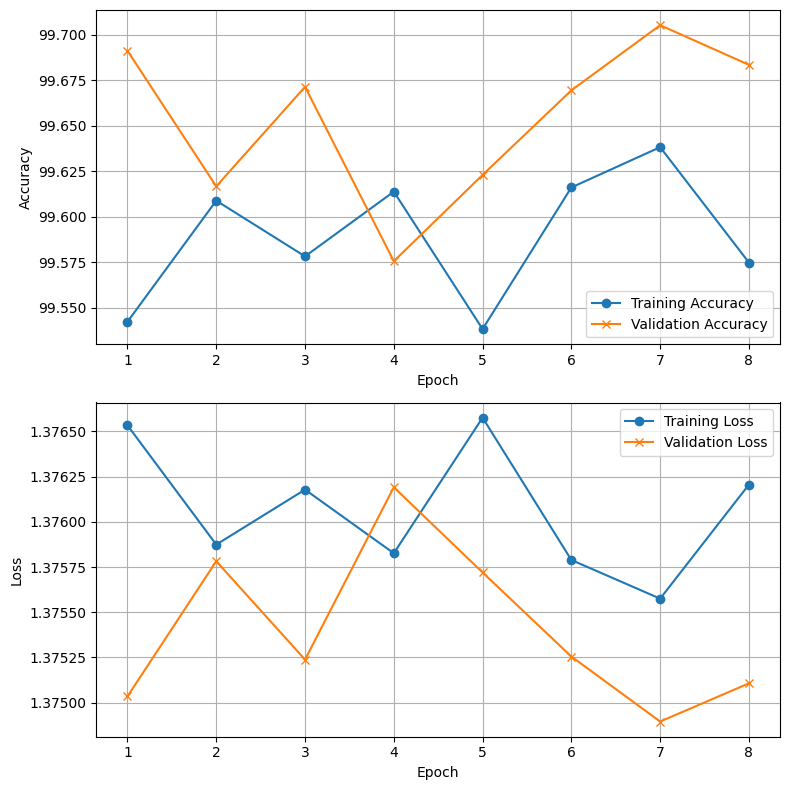

Fold 3/5
Training dataset size: (826658, 62)
Validation dataset size: (206665, 62)


100%|██████████| 3230/3230 [00:08<00:00, 377.26it/s]


Epoch: 1 	Training Loss: 1.375617 	Validation Loss: 1.376550
Epoch: 1 	Training Accuracy: 99.634190 	Validation Accuracy: 99.539835


100%|██████████| 3230/3230 [00:08<00:00, 394.93it/s]


Epoch: 2 	Training Loss: 1.376062 	Validation Loss: 1.375022
Epoch: 2 	Training Accuracy: 99.589189 	Validation Accuracy: 99.692256


100%|██████████| 3230/3230 [00:08<00:00, 381.86it/s]


Epoch: 3 	Training Loss: 1.375723 	Validation Loss: 1.375216
Epoch: 3 	Training Accuracy: 99.623544 	Validation Accuracy: 99.673384


100%|██████████| 3230/3230 [00:08<00:00, 373.01it/s]


Epoch: 4 	Training Loss: 1.375376 	Validation Loss: 1.374914
Epoch: 4 	Training Accuracy: 99.658021 	Validation Accuracy: 99.703385


100%|██████████| 3230/3230 [00:08<00:00, 380.20it/s]


Epoch: 5 	Training Loss: 1.375930 	Validation Loss: 1.375822
Epoch: 5 	Training Accuracy: 99.602980 	Validation Accuracy: 99.612416


100%|██████████| 3230/3230 [00:08<00:00, 379.83it/s]


Epoch: 6 	Training Loss: 1.375523 	Validation Loss: 1.375001
Epoch: 6 	Training Accuracy: 99.643504 	Validation Accuracy: 99.694675


100%|██████████| 3230/3230 [00:08<00:00, 376.88it/s]


Epoch: 7 	Training Loss: 1.375563 	Validation Loss: 1.375170
Epoch: 7 	Training Accuracy: 99.639512 	Validation Accuracy: 99.678707


100%|██████████| 3230/3230 [00:08<00:00, 378.19it/s]


Epoch: 8 	Training Loss: 1.375790 	Validation Loss: 1.375116
Epoch: 8 	Training Accuracy: 99.616286 	Validation Accuracy: 99.683062


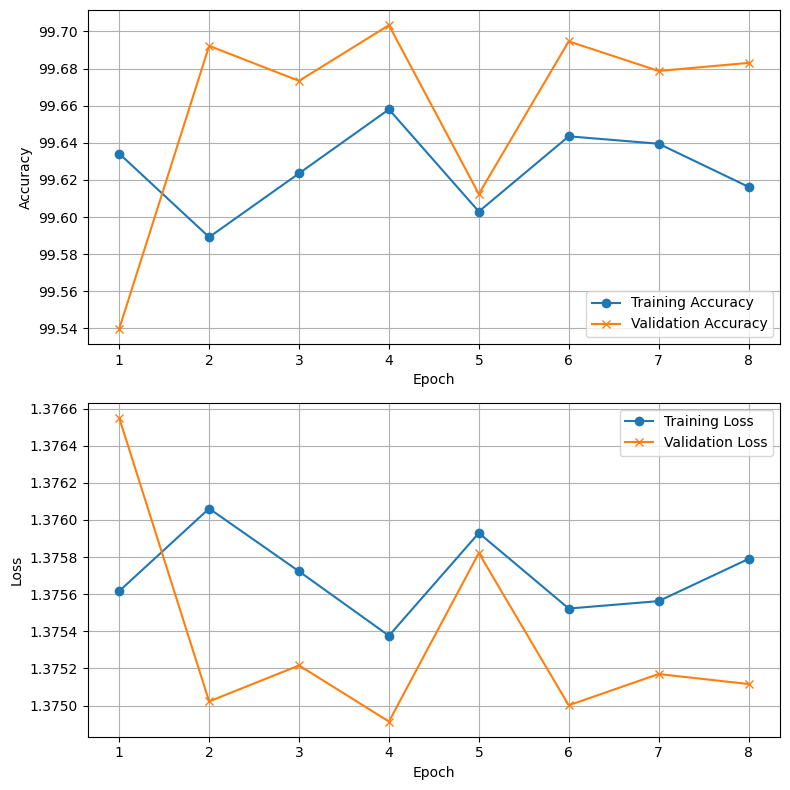

Fold 4/5
Training dataset size: (826659, 62)
Validation dataset size: (206664, 62)


100%|██████████| 3230/3230 [00:08<00:00, 376.27it/s]


Epoch: 1 	Training Loss: 1.375361 	Validation Loss: 1.375014
Epoch: 1 	Training Accuracy: 99.659473 	Validation Accuracy: 99.693706


100%|██████████| 3230/3230 [00:08<00:00, 378.49it/s]


Epoch: 2 	Training Loss: 1.375586 	Validation Loss: 1.375038
Epoch: 2 	Training Accuracy: 99.636489 	Validation Accuracy: 99.690802


100%|██████████| 3230/3230 [00:08<00:00, 387.65it/s]


Epoch: 3 	Training Loss: 1.375450 	Validation Loss: 1.375020
Epoch: 3 	Training Accuracy: 99.650521 	Validation Accuracy: 99.693222


100%|██████████| 3230/3230 [00:08<00:00, 393.71it/s]


Epoch: 4 	Training Loss: 1.375279 	Validation Loss: 1.375404
Epoch: 4 	Training Accuracy: 99.667578 	Validation Accuracy: 99.654512


100%|██████████| 3230/3230 [00:08<00:00, 377.74it/s]


Epoch: 5 	Training Loss: 1.375322 	Validation Loss: 1.375099
Epoch: 5 	Training Accuracy: 99.662981 	Validation Accuracy: 99.684996


100%|██████████| 3230/3230 [00:08<00:00, 382.45it/s]


Epoch: 6 	Training Loss: 1.375482 	Validation Loss: 1.375151
Epoch: 6 	Training Accuracy: 99.647134 	Validation Accuracy: 99.679673


100%|██████████| 3230/3230 [00:08<00:00, 384.06it/s]


Epoch: 7 	Training Loss: 1.375636 	Validation Loss: 1.375293
Epoch: 7 	Training Accuracy: 99.631650 	Validation Accuracy: 99.666125


100%|██████████| 3230/3230 [00:08<00:00, 381.06it/s]


Epoch: 8 	Training Loss: 1.375542 	Validation Loss: 1.375159
Epoch: 8 	Training Accuracy: 99.641085 	Validation Accuracy: 99.679189


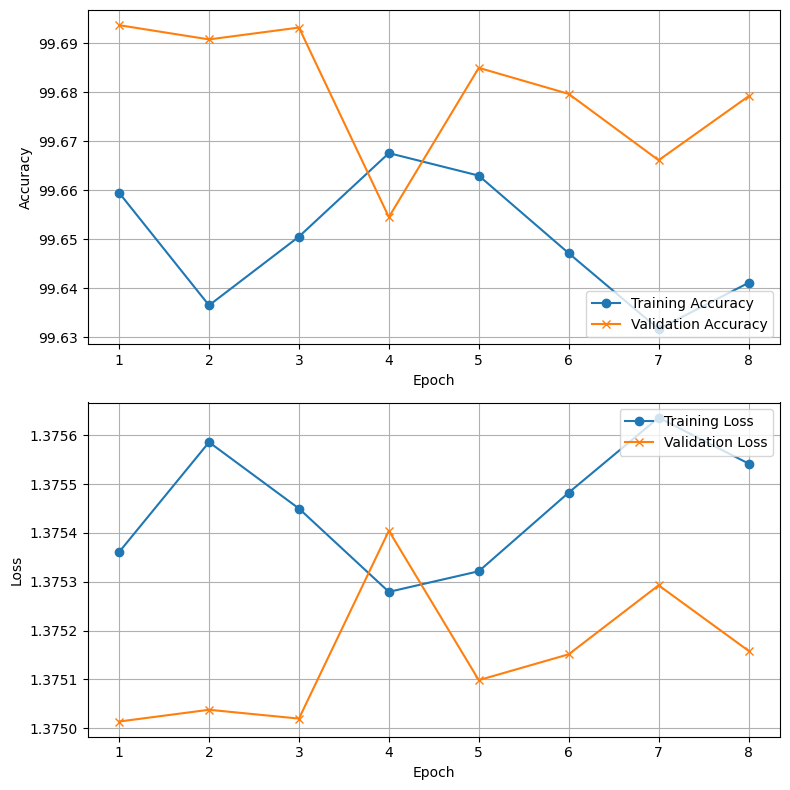

Fold 5/5
Training dataset size: (826659, 62)
Validation dataset size: (206664, 62)


100%|██████████| 3230/3230 [00:08<00:00, 378.38it/s]


Epoch: 1 	Training Loss: 1.375604 	Validation Loss: 1.375455
Epoch: 1 	Training Accuracy: 99.635037 	Validation Accuracy: 99.649189


100%|██████████| 3230/3230 [00:08<00:00, 379.67it/s]


Epoch: 2 	Training Loss: 1.375898 	Validation Loss: 1.375177
Epoch: 2 	Training Accuracy: 99.605279 	Validation Accuracy: 99.677254


100%|██████████| 3230/3230 [00:08<00:00, 381.17it/s]


Epoch: 3 	Training Loss: 1.375479 	Validation Loss: 1.374710
Epoch: 3 	Training Accuracy: 99.648102 	Validation Accuracy: 99.723222
Training loss decreased (1.375575 --> 1.375479).
Validation loss decreased (1.374895 --> 1.374710).  Saving model ...
Validation Loss: 1.3747, Validation Accuracy: 99.72%


100%|██████████| 3230/3230 [00:08<00:00, 385.73it/s]


Epoch: 4 	Training Loss: 1.375861 	Validation Loss: 1.376410
Epoch: 4 	Training Accuracy: 99.609633 	Validation Accuracy: 99.553381


100%|██████████| 3230/3230 [00:08<00:00, 380.92it/s]


Epoch: 5 	Training Loss: 1.375503 	Validation Loss: 1.377061
Epoch: 5 	Training Accuracy: 99.644956 	Validation Accuracy: 99.488542


100%|██████████| 3230/3230 [00:08<00:00, 378.56it/s]


Epoch: 6 	Training Loss: 1.375365 	Validation Loss: 1.374967
Epoch: 6 	Training Accuracy: 99.658989 	Validation Accuracy: 99.698061


100%|██████████| 3230/3230 [00:08<00:00, 383.91it/s]


Epoch: 7 	Training Loss: 1.375139 	Validation Loss: 1.375152
Epoch: 7 	Training Accuracy: 99.682094 	Validation Accuracy: 99.679673


100%|██████████| 3230/3230 [00:08<00:00, 385.49it/s]


Epoch: 8 	Training Loss: 1.375598 	Validation Loss: 1.374703
Epoch: 8 	Training Accuracy: 99.635158 	Validation Accuracy: 99.724674


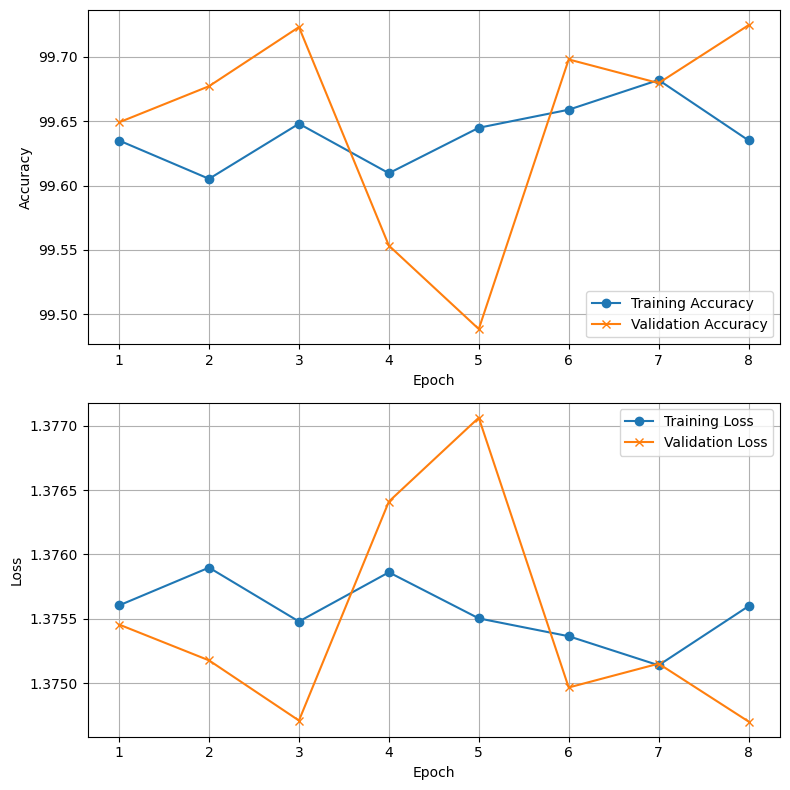

Average Training Accuracy: 99.61%
Average Validation Accuracy: 99.65%
Average Training Loss: 1.3758
Average Validation Loss: 1.3755


In [45]:

# Lists to store training and validation accuracies and losses for each fold
fold_training_accuracy = []
fold_validation_accuracy = []
fold_training_loss = []
fold_validation_loss = []

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity
train_loss_min = np.Inf # set initial "min" to infinity

# Loop through each fold
for fold, (train_index, valid_index) in enumerate(skf.split(X_train.values, y_train.values), 1):
    print(f"Fold {fold}/{n_splits}")
    
    # Get the training data and labels for this fold
    X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[valid_index]
    
    print("Training dataset size:", X_train_fold.shape)
    print("Validation dataset size:", X_valid_fold.shape)
    
    train_data = {'features': X_train_fold,  # Your feature data (Pandas DataFrame or similar)
            'labels': y_train_fold}     # Your label data
    valid_data = {'features': X_valid_fold,  # Your feature data (Pandas DataFrame or similar)
            'labels': y_valid_fold}     # Your label data    

    train_dataset = CustomTabularDataset(train_data)
    valid_dataset = CustomTabularDataset(valid_data)

    # Convert data to PyTorch tensors and create DataLoader instances
    train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=num_workers)
    
    # Train the model

    # Lists to store training and validation accuracy during training
    training_loss = np.array([])
    validation_loss = np.array([])

    training_accuracy = np.array([])
    validation_accuracy = np.array([])    
    
    # Moving model tensor to GPU if available
    model = model.to(device)

    for epoch in range(1, n_epochs+1):

        # keep track of training and validation loss and accuracy
        train_loss = 0.0
        valid_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0
        total_valid_correct = 0
        total_valid_samples = 0

        ###################
        # train the model #
        ###################

        # model by default is set to train
        model.train()

        for data, target in tqdm(train_loader):        

            # Moving input tensors to GPU if available
            data, target = data.to(device), target.to(device)

            # Forward prop:

            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data.float())    

            # Moving output tensor to GPU if available
            output = output.to(device)

            # calculate the batch loss
            loss = loss_function(output, target.reshape(-1).long())

            # Backward prop:

            # clear the gradients of all optimized variables
            optimizer.zero_grad()

            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()

            # perform a single optimization step (parameter update)
            optimizer.step()

            # Metrics:

            # update training loss
            train_loss += loss.item()

            # Calculate training accuracy
            _, predicted = torch.max(output, 1)
            total_train_correct += (predicted == target.view(*predicted.shape)).sum().item()
            total_train_samples += target.size(0)

        ######################
        # validate the model #
        ######################

        model.eval() # prep model for evaluation

        for data, target in tqdm(valid_loader):

            # Moving input tensors to GPU if available
            data, target = data.to(device), target.to(device)

            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data.float())
            output = output.to(device)

            # calculate the loss
            loss = loss_function(output, target.reshape(-1).long())        

            # update running validation loss
            valid_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(output, 1)
            total_valid_correct += (predicted == target.view(*predicted.shape)).sum().item()
            total_valid_samples += target.size(0)
            
        # print training/validation statistics

        train_acc = 100 * total_train_correct / total_train_samples
        valid_acc = 100 * total_valid_correct / total_valid_samples

        training_accuracy = np.append(training_accuracy, train_acc)
        validation_accuracy = np.append(validation_accuracy, valid_acc)

        # calculate average loss over an epoch
        train_loss = train_loss/len(train_loader)
        valid_loss = valid_loss/len(valid_loader)

        training_loss = np.append(training_loss, train_loss)
        validation_loss = np.append(validation_loss, valid_loss)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch,
            train_loss,
            valid_loss
        ))

        print('Epoch: {} \tTraining Accuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
            epoch,
            train_acc,
            valid_acc
        ))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min and train_loss <= train_loss_min:
            print('Training loss decreased ({:.6f} --> {:.6f}).'.format(
                train_loss_min,
                train_loss))
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                valid_loss))
            torch.save(model.state_dict(), 'model_pytorch_autoencoders.pt')
            valid_loss_min = valid_loss
            train_loss_min = train_loss            
            
            print(f"Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_acc:.2f}%")
    
    # Store accuracies and losses for this fold
    fold_training_accuracy.append(train_acc)
    fold_validation_accuracy.append(valid_acc)
    fold_training_loss.append(train_loss)
    fold_validation_loss.append(valid_loss)
    
    fig, ax = plt.subplots(2, 1, figsize=(8, 8))
    epochs = np.arange(1, n_epochs+1)

    # First row for accuracy
    ax[0].plot(epochs, training_accuracy, label='Training Accuracy', marker='o')
    ax[0].plot(epochs, validation_accuracy, label='Validation Accuracy', marker='x')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy', color='black')
    ax[0].tick_params(axis='y', labelcolor='black')
    ax[0].legend(loc='lower right')
    ax[0].grid(True)


    # Second row for loss
    ax[1].plot(epochs, training_loss, label='Training Loss', marker='o')
    ax[1].plot(epochs, validation_loss, label='Validation Loss', marker='x')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss', color='black')
    ax[1].tick_params(axis='y', labelcolor='black')
    ax[1].legend(loc='upper right')
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()    

# Calculate average metrics across all folds
avg_training_accuracy = np.mean(fold_training_accuracy)
avg_validation_accuracy = np.mean(fold_validation_accuracy)
avg_training_loss = np.mean(fold_training_loss)
avg_validation_loss = np.mean(fold_validation_loss)

print(f"Average Training Accuracy: {avg_training_accuracy:.2f}%")
print(f"Average Validation Accuracy: {avg_validation_accuracy:.2f}%")
print(f"Average Training Loss: {avg_training_loss:.4f}")
print(f"Average Validation Loss: {avg_validation_loss:.4f}")

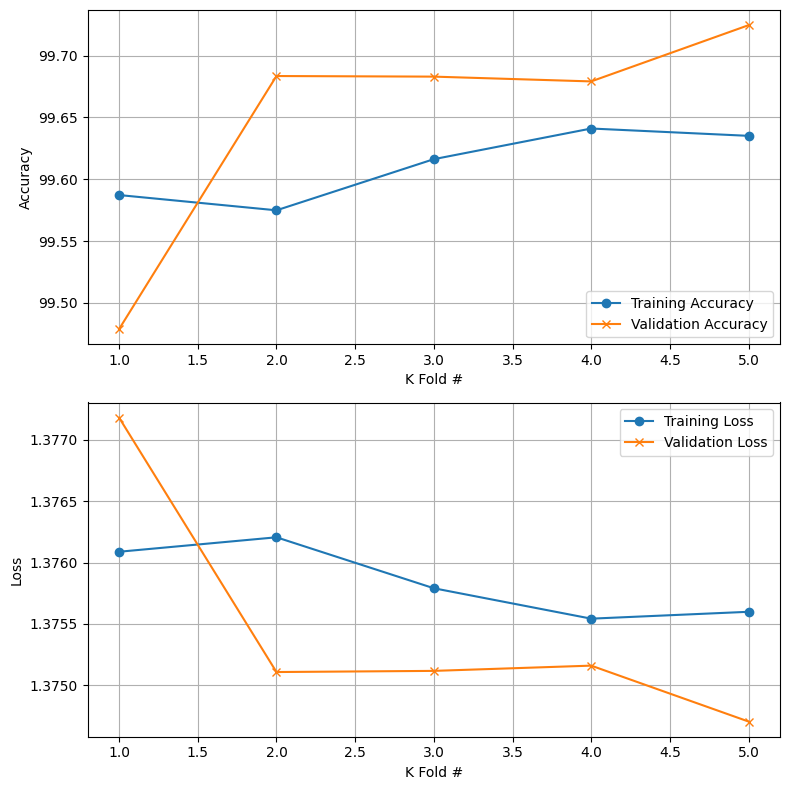

In [49]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8))
epochs = np.arange(1, n_splits+1)

# First row for accuracy
ax[0].plot(epochs, fold_training_accuracy, label='Training Accuracy', marker='o')
ax[0].plot(epochs, fold_validation_accuracy, label='Validation Accuracy', marker='x')
ax[0].set_xlabel('K Fold #')
ax[0].set_ylabel('Accuracy', color='black')
ax[0].tick_params(axis='y', labelcolor='black')
ax[0].legend(loc='lower right')
ax[0].grid(True)


# Second row for loss
ax[1].plot(epochs, fold_training_loss, label='Training Loss', marker='o')
ax[1].plot(epochs, fold_validation_loss, label='Validation Loss', marker='x')
ax[1].set_xlabel('K Fold #')
ax[1].set_ylabel('Loss', color='black')
ax[1].tick_params(axis='y', labelcolor='black')
ax[1].legend(loc='upper right')
ax[1].grid(True)

plt.tight_layout()
plt.show()

Testing phase:

In [50]:
print("Testing dataset size:", X_test.shape)
print("Testing target size:", y_test.shape)

X_test.head()

Testing dataset size: (182352, 62)
Testing target size: (182352, 1)


,Dur,sTos,dTos,sTtl,dTtl,sHops,dHops,TotPkts,SrcPkts,DstPkts,...,Cause_Start,Cause_Status,State_ACC,State_CON,State_ECO,State_FIN,State_INT,State_REQ,State_RST,State_URP
678382,-0.807085,-0.069046,-9.473906e-02,2.995804,-7.320131e-03,1.330671,-9.730588e-01,-0.167011,-0.146696,-0.115856,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
126233,1.898934,-0.069046,-1.773502e-16,-0.329976,1.190749e-13,-0.352692,-1.939318e-13,-0.126725,-0.092389,-0.115856,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
259255,0.793358,-0.069046,-9.473906e-02,-0.329976,-7.320131e-03,-0.352692,-9.730588e-01,-0.126725,-0.092389,-0.115856,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
171362,1.887680,-0.069046,-1.773502e-16,-0.329976,1.190749e-13,-0.352692,-1.939318e-13,-0.126725,-0.092389,-0.115856,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
824752,-0.807085,-0.069046,-1.773502e-16,-0.329976,1.190749e-13,-0.352692,-1.939318e-13,-0.167011,-0.146696,-0.115856,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [51]:
y_test.head()

,Attack Type
678382,0
126233,7
259255,0
171362,7
824752,7


In [52]:
test_data = {'features': X_test,  # Your feature data (Pandas DataFrame or similar)
        'labels': y_test}     # Your label data

test_dataset = CustomTabularDataset(test_data)

In [53]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
    num_workers=num_workers)

In [54]:
model.load_state_dict(torch.load('model_pytorch_autoencoders.pt'))

<All keys matched successfully>

In [55]:
le_name_mapping = {'Benign': 0, 'HTTPFlood': 1, 'ICMPFlood': 2, 'SYNFlood': 3, 'SYNScan': 4, 'SlowrateDoS': 5, 'TCPConnectScan': 6, 'UDPFlood': 7, 'UDPScan': 8}
le_name_mapping

{'Benign': 0,
 'HTTPFlood': 1,
 'ICMPFlood': 2,
 'SYNFlood': 3,
 'SYNScan': 4,
 'SlowrateDoS': 5,
 'TCPConnectScan': 6,
 'UDPFlood': 7,
 'UDPScan': 8}

In [56]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0

class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))

# Initialize empty tensors for predictions and targets
all_preds_tensors = torch.tensor([])
all_targets_tensors = torch.tensor([])

# Moving model tensor to GPU if available
model = model.to(device)

model.eval() # prep model for evaluation

for data, target in tqdm(test_loader):
    
    # Moving input tensors to GPU if available
    data, target = data.to(device), target.to(device)    
    
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data.float())
    output = output.to(device)    
    
    # calculate the loss
    loss = loss_function(output, target.reshape(-1).long())
    
    # update test loss
    test_loss += loss.item()*data.size(0)
    
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    
    # Concatenate predictions and targets tensors
    all_preds_tensors = torch.cat((all_preds_tensors, pred.cpu()), dim=0)
    all_targets_tensors = torch.cat((all_targets_tensors, target.squeeze().cpu()), dim=0)
    
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    
    # calculate test accuracy for each object class
    for i in range(data.shape[0]):
        label = int(target.data[i].item())
        class_correct[label] += int(correct[i].item())
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

label_map = {}
for k, v in le_name_mapping.items():
    label_map[v] = k

for i in range(num_classes):
    if class_total[i] > 0:
        print(f'Test Accuracy of {str(i)}-{label_map[i]:<25}: {100 * class_correct[i] / class_total[i]:.6f}% ({int(np.sum(class_correct[i])):<2}/{int(np.sum(class_total[i])):<2})')
    else:
        print(f'Test Accuracy of {label_map[i]:<25}: N/A (no training examples)')

print(f'\nTest Accuracy (Overall): {100. * np.sum(class_correct) / np.sum(class_total):.6f}% ({int(np.sum(class_correct))} / {int(np.sum(class_total))})')

100%|██████████| 2850/2850 [00:14<00:00, 190.03it/s]

Test Loss: 1.374811

Test Accuracy of 0-Benign                   : 99.993020% (71624/71629)
Test Accuracy of 1-HTTPFlood                : 99.398731% (20995/21122)
Test Accuracy of 2-ICMPFlood                : 100.000000% (173/173)
Test Accuracy of 3-SYNFlood                 : 87.517147% (1276/1458)
Test Accuracy of 4-SYNScan                  : 99.634065% (2995/3006)
Test Accuracy of 5-SlowrateDoS              : 98.322545% (10785/10969)
Test Accuracy of 6-TCPConnectScan           : 99.767287% (3001/3008)
Test Accuracy of 7-UDPFlood                 : 100.000000% (68601/68601)
Test Accuracy of 8-UDPScan                  : 99.748533% (2380/2386)

Test Accuracy (Overall): 99.713740% (181830 / 182352)


Accuracy: 0.9971374273300171 

Precision: 0.9971864223480225 

Recall: 0.9971374869346619 

F1 Score: 0.9971179962158203 

Confusion Matrix:
tensor([[71624,     3,     0,     0,     0,     0,     2,     0,     0],
        [    0, 20995,     0,     0,     1,   125,     1,     0,     0],
        [    0,     0,   173,     0,     0,     0,     0,     0,     0],
        [    0,     0,     0,  1276,     0,     2,   180,     0,     0],
        [    0,     0,     0,     6,  2995,     0,     0,     0,     5],
        [    9,   175,     0,     0,     0, 10785,     0,     0,     0],
        [    0,     0,     0,     0,     6,     0,  3001,     0,     1],
        [    0,     0,     0,     0,     0,     0,     0, 68601,     0],
        [    0,     0,     0,     1,     5,     0,     0,     0,  2380]])


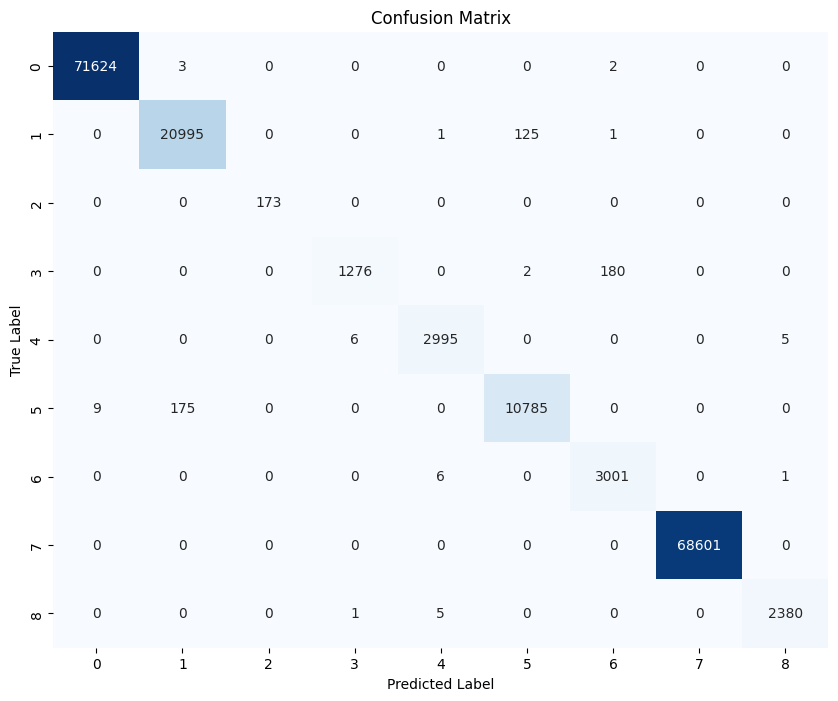

In [57]:
import torch
from torchmetrics import Accuracy, Precision, Recall, F1Score, ConfusionMatrix
import matplotlib.pyplot as plt

# Initialize evaluation metrics
accuracy = Accuracy(task="multiclass", num_classes=num_classes)
precision = Precision(task="multiclass", num_classes=num_classes, average='weighted')
recall = Recall(task="multiclass", num_classes=num_classes, average='weighted')
f1 = F1Score(task="multiclass", num_classes=num_classes, average='weighted')
conf_matrix = ConfusionMatrix(task="multiclass", num_classes=num_classes)

# Calculate evaluation metrics
accuracy_value = accuracy(all_preds_tensors, all_targets_tensors)
precision_value = precision(all_preds_tensors, all_targets_tensors)
recall_value = recall(all_preds_tensors, all_targets_tensors)
f1_value = f1(all_preds_tensors, all_targets_tensors)
conf_matrix_value = conf_matrix(all_preds_tensors, all_targets_tensors)

# Print the metrics
print(f"Accuracy: {accuracy_value} \n")
print(f"Precision: {precision_value} \n")
print(f"Recall: {recall_value} \n")
print(f"F1 Score: {f1_value} \n")
print(f"Confusion Matrix:\n{conf_matrix_value}")

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix.compute().numpy(), cmap='Blues', annot=True, fmt='d', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

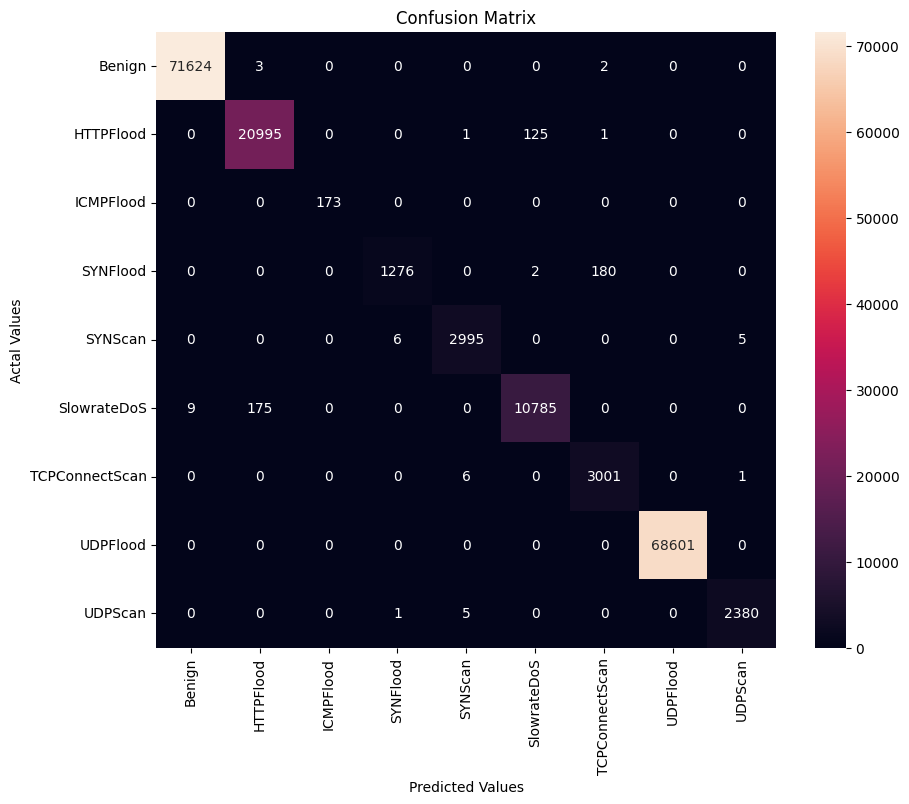

In [58]:
from sklearn.metrics import confusion_matrix

# Creating  a confusion matrix,which compares the y_test and y_pred
cm = confusion_matrix(all_targets_tensors.numpy(), all_preds_tensors.numpy())

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = le_name_mapping.keys(), 
                     columns = le_name_mapping.keys())

#Plotting the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [59]:
print(le_name_mapping)
cm_df

{'Benign': 0, 'HTTPFlood': 1, 'ICMPFlood': 2, 'SYNFlood': 3, 'SYNScan': 4, 'SlowrateDoS': 5, 'TCPConnectScan': 6, 'UDPFlood': 7, 'UDPScan': 8}


,Benign,HTTPFlood,ICMPFlood,SYNFlood,SYNScan,SlowrateDoS,TCPConnectScan,UDPFlood,UDPScan
Benign,71624,3,0,0,0,0,2,0,0
HTTPFlood,0,20995,0,0,1,125,1,0,0
ICMPFlood,0,0,173,0,0,0,0,0,0
SYNFlood,0,0,0,1276,0,2,180,0,0
SYNScan,0,0,0,6,2995,0,0,0,5
SlowrateDoS,9,175,0,0,0,10785,0,0,0
TCPConnectScan,0,0,0,0,6,0,3001,0,1
UDPFlood,0,0,0,0,0,0,0,68601,0
UDPScan,0,0,0,1,5,0,0,0,2380
